In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

import rasterio
import geopandas as gpd

import iceplant_detection_functions as ipf
import model_prep_and_evals as mpe

import warnings

## Import train/test sets

In [2]:
X_train = pd.read_csv(os.path.join(os.getcwd(),'feature_selection','train_set.csv')).loc[:,'r':'avg_lidar']
y_train = pd.read_csv(os.path.join(os.getcwd(),'feature_selection','train_set.csv')).loc[:,'iceplant'] 

X_test = pd.read_csv(os.path.join(os.getcwd(),'feature_selection','test_set.csv')).loc[:,'r':'avg_lidar']
y_test = pd.read_csv(os.path.join(os.getcwd(),'feature_selection','test_set.csv')).loc[:,'iceplant']

In [4]:
X_train.head(3)

,r,g,b,nir,ndvi,year,month,day_in_year,lidar,max_lidar,min_lidar,min_max_diff,avg_lidar
0,43,51,78,89,0.348485,2012,5,126,2,10,0,10,3.000000
1,65,59,84,79,0.097222,2012,5,126,0,6,0,6,1.000000
2,81,86,93,132,0.239437,2012,5,126,11,14,6,8,9.222222


In [9]:
mpe.iceplant_proportions(np.array(y_test))

no-iceplant:iceplant ratio     2.5 :1
          counts  percentage
iceplant                    
0         106302       71.04
1          43330       28.96



In [8]:
mpe.iceplant_proportions(np.array(y_train))

no-iceplant:iceplant ratio     2.4 :1
          counts  percentage
iceplant                    
0         247696       70.95
1         101425       29.05



## Train model

In [10]:
from dask_ml.wrappers import ParallelPostFit

In [11]:
t0 = time.time()

rfc = ParallelPostFit(RandomForestClassifier(n_estimators = 100, random_state = 42))
rfc.fit(X_train, y_train)

print('time to train: ', (time.time()-t0))

time to train:  41.22987413406372


In [12]:
predictions = rfc.predict(X_test)
mpe.print_threshold_metrics(y_test, predictions)


true negatives: 105742     false positives: 560
false negatives: 696     true positives: 42634

sensitivity (TP/P): 98.39 %
specificity (TN/N): 99.47 %
G-mean:  0.99

precision (TP/(TP+FP)): 98.7 %

MCC:  0.9795822912045534

F1-measure:  0.98548
F0.5-measure (min false positives):  0.98641
F2-measure (min false negatives)  :  0.98456

accuracy: 99.16 %



In [13]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rfc, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

In [14]:
forest_importances = pd.Series(result.importances_mean, index=['r', 'g', 'b', 'nir', 'ndvi', 
                                                               'year', 'month', 'day_in_year',
                                                              'lidar', 'max_lidar', 'min_lidar', 'min_max_diff', 'avg_lida'])


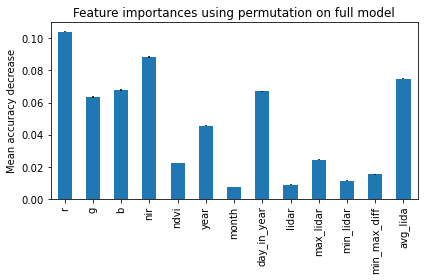

In [15]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()